# Purchase-Recommendation

#### Problem statement
In this data challenge, we are building collaborative filtering models for recommending product items. The steps below aim to recommend users their top 10 items to place into their basket. The final output will be a csv file in the output folder, and a function that searches for a recommendation list based on a speficied user:

> Input: user - customer ID  
> Returns: ranked list of items (product IDs), that the user is most likely to want to put in his/her (empty) "basket"


#### Importing the relevant libraries

In [105]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import turicreate as tc
from sklearn.model_selection import train_test_split
import os
import time
import seaborn as sns
# We can override the default matplotlib styles with those of Seaborn
sns.set()## Importing the relevant libraries

#### Load data

In [161]:
# Load the data from a .csv
customer_data = pd.read_csv(os.path.join(os.path.pardir,'data','raw','recommend_1.csv'))
transactions_data = pd.read_csv(os.path.join(os.path.pardir,'data','raw','trx_data.csv'))

In [5]:
customer_data.shape

(1000, 1)

In [88]:
customer_data.head()

""
customerId
1553
20400
19750
6334
27773


In [6]:
transactions_data.shape

(62483, 2)

In [9]:
transactions_data.head()

,customerId,products
0,0,20
1,1,2|2|23|68|68|111|29|86|107|152
2,2,111|107|29|11|11|11|33|23
3,3,164|227
4,5,2|2


##  Data preparation

> Our goal here is to break down each list of items in the products column into rows and count the number of products bought by a user
> ###### Create data with user, item, and target field
>- This table will be an input for our modeling later
>- In this case, our user is `customerId`, `productId`, and `purchase_count`

In [65]:
# example 1: split product items
transactions_data['products'] = transactions_data['products'].apply(lambda x: [int(i) for i in x.split('|')])
transactions_data.head(2).set_index('customerId')['products'].apply(pd.Series).reset_index()

,customerId,0,1,2,3,4,5,6,7,8,9
0,0,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2.0,2.0,23.0,68.0,68.0,111.0,29.0,86.0,107.0,152.0


In [67]:
# example 2: organize a given table into a dataframe with customerId, single productId, and purchase count
pd.melt(transactions_data.head(2).set_index('customerId')['products'].apply(pd.Series).reset_index(), 
             id_vars=['customerId'],
             value_name='products') \
    .dropna().drop(['variable'], axis=1) \
    .groupby(['customerId', 'products']) \
    .agg({'products': 'count'}) \
    .rename(columns={'products': 'purchase_count'}) \
    .reset_index() \
    .rename(columns={'products': 'productId'})

,customerId,productId,purchase_count
0,0,20.0,1
1,1,2.0,2
2,1,23.0,1
3,1,29.0,1
4,1,68.0,2
5,1,86.0,1
6,1,107.0,1
7,1,111.0,1
8,1,152.0,1


### Create data with user, item, and target field
* This table will be an input for our modeling later
    * In this case, our user is `customerId`, `productId`, and `purchase_count`

In [73]:
s=time.time()

df = pd.melt(transactions_data.set_index('customerId')['products'].apply(pd.Series).reset_index(), 
             id_vars=['customerId'],
             value_name='products') \
    .dropna().drop(['variable'], axis=1) \
    .groupby(['customerId', 'products']) \
    .agg({'products': 'count'}) \
    .rename(columns={'products': 'purchase_count'}) \
    .reset_index() \
    .rename(columns={'products': 'productId'})
df['productId'] = df['productId'].astype(np.int64)
print("Execution time:", round((time.time()-s)/60,2), "minutes")

Execution time: 0.39 minutes


In [74]:
df

,customerId,productId,purchase_count
0,0,1,2
1,0,13,1
2,0,19,3
3,0,20,1
4,0,31,2
5,0,52,1
6,0,69,2
7,0,93,3
8,0,136,2
9,0,157,1


### Create dummy

> - Dummy for marking whether a customer bought that item or not.
> - If one buys an item, then purchase_dummy are marked as 1
> - Why create a dummy instead of normalizing it, you ask? Normalizing the purchase count, say by each user, would not work because customers may have different buying frequency don’t have the same taste. However, we can normalize items by purchase frequency across all users

In [75]:
def create_data_dummy(data):
    data_dummy = df.copy()
    data_dummy['purchase_dummy'] = 1
    return data_dummy

In [77]:
data_dummy = create_data_dummy(df)

In [158]:
data_dummy['purchase_dummy'].unique()

array([1])

In [79]:
data_dummy.head()

,customerId,productId,purchase_count,purchase_dummy
0,0,1,2,1
1,0,13,1,1
2,0,19,3,1
3,0,20,1,1
4,0,31,2,1


### Normalize item values across users
* To do this, we normalize purchase frequency of each item across users by first creating a user-item matrix as follows

In [81]:
df_matrix = pd.pivot_table(df, values='purchase_count', index='customerId', columns='productId')
df_matrix.head()

productId,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
customerId,,,,,,,,,,,,,,,,,,,,,
0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [82]:
(df_matrix.shape)

(24429, 300)

In [86]:
df_matrix_norm = (df_matrix-df_matrix.min())/(df_matrix.max()-df_matrix.min())
print(df_matrix_norm.shape)
df_matrix_norm.head()

(24429, 300)


productId,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
customerId,,,,,,,,,,,,,,,,,,,,,
0,NaN,0.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,0.166667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [93]:
# create a table for input to the modeling

d = df_matrix_norm.reset_index()
d.index.names = ['scaled_purchase_freq']
data_norm = pd.melt(d, id_vars=['customerId'], value_name='scaled_purchase_freq').dropna()
print(data_norm.shape)
data_norm.head()

(133585, 3)


,customerId,productId,scaled_purchase_freq
9,9,0,0.133333
25,25,0,0.133333
32,33,0,0.133333
35,36,0,0.133333
43,44,0,0.133333


#### Define a function for normalizing data
The above steps can be combined to a function defined below:


In [96]:
def normalize_data(data):
    df_matrix = pd.pivot_table(df, values='purchase_count', index='customerId', columns='productId')
    df_matrix_norm = (df_matrix-df_matrix.min())/(df_matrix.max()-df_matrix.min())
    d = df_matrix_norm.reset_index()
    d.index.names = ['scaled_purchase_freq']
    return pd.melt(d, id_vars=['customerId'], value_name='scaled_purchase_freq').dropna()

* We can normalize the their purchase history, from 0-1 (with 1 being the most number of purchase for an item and 0 being 0 purchase count for that item).

## Split train and test set
* Splitting the data into training and testing sets is an important part of evaluating predictive modeling, in this case a collaborative filtering model. Typically, we use a larger portion of the data for training and a smaller portion for testing. 
* We use 80:20 ratio for our train-test set size.
* Our training portion will be used to develop a predictive model, while the other to evaluate the model's performance.
* Now that we have three datasets with purchase counts, purchase dummy, and scaled purchase counts, we would like to split each.

In [97]:
def split_data(data):
    '''
    Splits dataset into training and test set.
    
    Args:
        data (pandas.DataFrame)
        
    Returns
        train_data (tc.SFrame)
        test_data (tc.SFrame)
    '''
    train, test = train_test_split(data, test_size = .2)
    train_data = tc.SFrame(train)
    test_data = tc.SFrame(test)
    return train_data, test_data

> Now that we have three datasets with purchase counts, purchase dummy, and scaled purchase counts, we would like to split each for modeling.

In [106]:
train_data, test_data = split_data(df)
train_data_dummy, test_data_dummy = split_data(data_dummy)
train_data_norm, test_data_norm = split_data(data_norm)

In [155]:
type(train_data)

turicreate.data_structures.sframe.SFrame

In [157]:
train_data

customerId,productId,purchase_count
4485,105,1
16674,155,1
25999,38,1
19288,50,1
18541,6,3
19858,223,1
22903,224,1
14219,89,1
12571,0,3
6010,77,1


>## Baseline Model
Before running a more complicated approach such as collaborative filtering, we would like to use a baseline model to compare and evaluate models. Since baseline typically uses a very simple approach, techniques used beyond this approach should be chosen if they show relatively better accuracy and complexity.

> ###  Using a Popularity model as a baseline
> * The popularity model takes the most popular items for recommendation. These items are products with the highest number of sells across customers.
> * We use `turicreate` library for running and evaluating both baseline and collaborative filtering models below
> * Training data is used for model selection

> #### Using purchase counts

In [109]:
# variables to define field names
user_id = 'customerId'
item_id = 'productId'
target = 'purchase_count'
users_to_recommend = list(transactions_data[user_id])
n_rec = 10 # number of items to recommend
n_display = 30

In [110]:
popularity_model = tc.popularity_recommender.create(train_data, 
                                                    user_id=user_id, 
                                                    item_id=item_id, 
                                                    target=target)

Preparing data set.

Data has 106868 observations with 23292 users and 300 items.

Data prepared in: 0.195572s

106868 observations to process; with 300 unique items.

In [111]:
# Get recommendations for a list of users to recommend (from customers file)
# Printed below is head / top 30 rows for first 3 customers with 10 recommendations each

popularity_recomm = popularity_model.recommend(users=users_to_recommend, k=n_rec)
popularity_recomm.print_rows(n_display)

recommendations finished on 1000/62483 queries. users per second: 37479.9

recommendations finished on 2000/62483 queries. users per second: 67175

recommendations finished on 3000/62483 queries. users per second: 87265.1

recommendations finished on 4000/62483 queries. users per second: 107236

recommendations finished on 5000/62483 queries. users per second: 126926

recommendations finished on 6000/62483 queries. users per second: 144516

recommendations finished on 7000/62483 queries. users per second: 153785

recommendations finished on 8000/62483 queries. users per second: 159962

recommendations finished on 9000/62483 queries. users per second: 170986

recommendations finished on 10000/62483 queries. users per second: 178221

recommendations finished on 12000/62483 queries. users per second: 161810

recommendations finished on 13000/62483 queries. users per second: 114991

recommendations finished on 11000/62483 queries. users per second: 184747

recommendations finished on 14000/62483 queries. users per second: 118968

recommendations finished on 15000/62483 queries. users per second: 121584

recommendations finished on 16000/62483 queries. users per second: 121458

recommendations finished on 17000/62483 queries. users per second: 122836

recommendations finished on 18000/62483 queries. users per second: 122181

recommendations finished on 19000/62483 queries. users per second: 123780

recommendations finished on 20000/62483 queries. users per second: 125107

recommendations finished on 21000/62483 queries. users per second: 126479

recommendations finished on 22000/62483 queries. users per second: 125144

recommendations finished on 23000/62483 queries. users per second: 115772

recommendations finished on 24000/62483 queries. users per second: 113871

recommendations finished on 25000/62483 queries. users per second: 115257

recommendations finished on 26000/62483 queries. users per second: 117938

recommendations finished on 27000/62483 queries. users per second: 120635

recommendations finished on 28000/62483 queries. users per second: 114840

recommendations finished on 29000/62483 queries. users per second: 116517

recommendations finished on 30000/62483 queries. users per second: 119133

recommendations finished on 31000/62483 queries. users per second: 121701

recommendations finished on 32000/62483 queries. users per second: 124085

recommendations finished on 33000/62483 queries. users per second: 125673

recommendations finished on 34000/62483 queries. users per second: 114612

recommendations finished on 35000/62483 queries. users per second: 115902

recommendations finished on 36000/62483 queries. users per second: 117008

recommendations finished on 37000/62483 queries. users per second: 112644

recommendations finished on 38000/62483 queries. users per second: 113896

recommendations finished on 39000/62483 queries. users per second: 115495

recommendations finished on 40000/62483 queries. users per second: 117068

recommendations finished on 41000/62483 queries. users per second: 109070

recommendations finished on 42000/62483 queries. users per second: 110198

recommendations finished on 43000/62483 queries. users per second: 111328

recommendations finished on 44000/62483 queries. users per second: 110890

recommendations finished on 45000/62483 queries. users per second: 111977

recommendations finished on 46000/62483 queries. users per second: 113049

recommendations finished on 47000/62483 queries. users per second: 109187

recommendations finished on 48000/62483 queries. users per second: 109110

recommendations finished on 49000/62483 queries. users per second: 109582

recommendations finished on 50000/62483 queries. users per second: 111225

recommendations finished on 51000/62483 queries. users per second: 112127

recommendations finished on 52000/62483 queries. users per second: 112669

recommendations finished on 53000/62483 queries. users per second: 112508

recommendations finished on 54000/62483 queries. users per second: 112019

recommendations finished on 55000/62483 queries. users per second: 112966

recommendations finished on 56000/62483 queries. users per second: 113095

recommendations finished on 57000/62483 queries. users per second: 113814

recommendations finished on 58000/62483 queries. users per second: 114050

recommendations finished on 59000/62483 queries. users per second: 114866

recommendations finished on 60000/62483 queries. users per second: 115702

recommendations finished on 61000/62483 queries. users per second: 116334

recommendations finished on 62000/62483 queries. users per second: 116472

+------------+-----------+--------------------+------+
| customerId | productId |       score        | rank |
+------------+-----------+--------------------+------+
|     0      |    132    | 3.235294117647059  |  1   |
|     0      |     34    | 3.065843621399177  |  2   |
|     0      |     37    | 2.9798387096774195 |  3   |
|     0      |     0     | 2.9637254901960786 |  4   |
|     0      |    248    | 2.8780487804878048 |  5   |
|     0      |     3     | 2.8553459119496853 |  6   |
|     0      |    110    | 2.824561403508772  |  7   |
|     0      |     27    | 2.742424242424242  |  8   |
|     0      |    230    | 2.6666666666666665 |  9   |
|     0      |     10    | 2.647761194029851  |  10  |
|     1      |    132    | 3.235294117647059  |  1   |
|     1      |     34    | 3.065843621399177  |  2   |
|     1      |     37    | 2.9798387096774195 |  3   |
|     1      |     0     | 2.9637254901960786 |  4   |
|     1      |    248    | 2.8780487804878048 |  5   |
|     1   

#### Define a `model` function for model selection

In [112]:
# Since turicreate is very accessible library, we can define a model selection function as below

def model(train_data, name, user_id, item_id, target, users_to_recommend, n_rec, n_display):
    if name == 'popularity':
        model = tc.popularity_recommender.create(train_data, 
                                                    user_id=user_id, 
                                                    item_id=item_id, 
                                                    target=target)
    elif name == 'cosine':
        model = tc.item_similarity_recommender.create(train_data, 
                                                    user_id=user_id, 
                                                    item_id=item_id, 
                                                    target=target, 
                                                    similarity_type='cosine')
    elif name == 'pearson':
        model = tc.item_similarity_recommender.create(train_data, 
                                                    user_id=user_id, 
                                                    item_id=item_id, 
                                                    target=target, 
                                                    similarity_type='pearson')
        
    recom = model.recommend(users=users_to_recommend, k=n_rec)
    recom.print_rows(n_display)
    return model

#### Popularity Model as Baseline
> The popularity model takes the most popular items for recommendation. These items are products with the highest number of sells across customers.
> * Training data is used for model selection 
***
**Using purchase count**

In [114]:
name = 'popularity'
target = 'purchase_count'
popularity = model(train_data, name, user_id, item_id, target, users_to_recommend, n_rec, n_display)

Preparing data set.

Data has 106868 observations with 23292 users and 300 items.

Data prepared in: 0.198676s

106868 observations to process; with 300 unique items.

recommendations finished on 1000/62483 queries. users per second: 98804.5

recommendations finished on 2000/62483 queries. users per second: 145001

recommendations finished on 3000/62483 queries. users per second: 128700

recommendations finished on 4000/62483 queries. users per second: 148417

recommendations finished on 5000/62483 queries. users per second: 159790

recommendations finished on 6000/62483 queries. users per second: 172707

recommendations finished on 7000/62483 queries. users per second: 183978

recommendations finished on 8000/62483 queries. users per second: 180844

recommendations finished on 9000/62483 queries. users per second: 157224

recommendations finished on 10000/62483 queries. users per second: 159724

recommendations finished on 11000/62483 queries. users per second: 164201

recommendations finished on 12000/62483 queries. users per second: 166295

recommendations finished on 13000/62483 queries. users per second: 169671

recommendations finished on 14000/62483 queries. users per second: 170624

recommendations finished on 15000/62483 queries. users per second: 158846

recommendations finished on 16000/62483 queries. users per second: 161513

recommendations finished on 17000/62483 queries. users per second: 164051

recommendations finished on 18000/62483 queries. users per second: 167439

recommendations finished on 19000/62483 queries. users per second: 168731

recommendations finished on 20000/62483 queries. users per second: 163244

recommendations finished on 21000/62483 queries. users per second: 164877

recommendations finished on 22000/62483 queries. users per second: 165651

recommendations finished on 23000/62483 queries. users per second: 160511

recommendations finished on 24000/62483 queries. users per second: 144044

recommendations finished on 25000/62483 queries. users per second: 146482

recommendations finished on 26000/62483 queries. users per second: 150249

recommendations finished on 27000/62483 queries. users per second: 152336

recommendations finished on 28000/62483 queries. users per second: 153394

recommendations finished on 29000/62483 queries. users per second: 155185

recommendations finished on 30000/62483 queries. users per second: 156476

recommendations finished on 31000/62483 queries. users per second: 157445

recommendations finished on 32000/62483 queries. users per second: 155709

recommendations finished on 33000/62483 queries. users per second: 144178

recommendations finished on 34000/62483 queries. users per second: 137824

recommendations finished on 35000/62483 queries. users per second: 138354

recommendations finished on 36000/62483 queries. users per second: 136872

recommendations finished on 37000/62483 queries. users per second: 134582

recommendations finished on 38000/62483 queries. users per second: 133180

recommendations finished on 39000/62483 queries. users per second: 131940

recommendations finished on 40000/62483 queries. users per second: 119221

recommendations finished on 41000/62483 queries. users per second: 119991

recommendations finished on 42000/62483 queries. users per second: 120966

recommendations finished on 43000/62483 queries. users per second: 122103

recommendations finished on 44000/62483 queries. users per second: 123182

recommendations finished on 45000/62483 queries. users per second: 119611

recommendations finished on 46000/62483 queries. users per second: 120709

recommendations finished on 47000/62483 queries. users per second: 121522

recommendations finished on 48000/62483 queries. users per second: 122342

recommendations finished on 49000/62483 queries. users per second: 119572

recommendations finished on 50000/62483 queries. users per second: 119282

recommendations finished on 51000/62483 queries. users per second: 115875

recommendations finished on 52000/62483 queries. users per second: 116136

recommendations finished on 53000/62483 queries. users per second: 117224

recommendations finished on 54000/62483 queries. users per second: 118560

recommendations finished on 55000/62483 queries. users per second: 119205

recommendations finished on 56000/62483 queries. users per second: 119970

recommendations finished on 57000/62483 queries. users per second: 119520

recommendations finished on 58000/62483 queries. users per second: 119782

recommendations finished on 59000/62483 queries. users per second: 119091

recommendations finished on 60000/62483 queries. users per second: 117198

recommendations finished on 61000/62483 queries. users per second: 117773

recommendations finished on 62000/62483 queries. users per second: 115448

+------------+-----------+--------------------+------+
| customerId | productId |       score        | rank |
+------------+-----------+--------------------+------+
|     0      |    132    | 3.235294117647059  |  1   |
|     0      |     34    | 3.065843621399177  |  2   |
|     0      |     37    | 2.9798387096774195 |  3   |
|     0      |     0     | 2.9637254901960786 |  4   |
|     0      |    248    | 2.8780487804878048 |  5   |
|     0      |     3     | 2.8553459119496853 |  6   |
|     0      |    110    | 2.824561403508772  |  7   |
|     0      |     27    | 2.742424242424242  |  8   |
|     0      |    230    | 2.6666666666666665 |  9   |
|     0      |     10    | 2.647761194029851  |  10  |
|     1      |    132    | 3.235294117647059  |  1   |
|     1      |     34    | 3.065843621399177  |  2   |
|     1      |     37    | 2.9798387096774195 |  3   |
|     1      |     0     | 2.9637254901960786 |  4   |
|     1      |    248    | 2.8780487804878048 |  5   |
|     1   

> **Using purchase dummy**

In [115]:
name = 'popularity'
target = 'purchase_dummy'
pop_dummy = model(train_data_dummy, name, user_id, item_id, target, users_to_recommend, n_rec, n_display)

Warning: Ignoring columns purchase_count;

To use these columns in scoring predictions, use a model that allows the use of additional features.

Preparing data set.

Data has 106868 observations with 23286 users and 300 items.

Data prepared in: 0.21892s

106868 observations to process; with 300 unique items.

recommendations finished on 1000/62483 queries. users per second: 70358.1

recommendations finished on 2000/62483 queries. users per second: 112708

recommendations finished on 3000/62483 queries. users per second: 144161

recommendations finished on 4000/62483 queries. users per second: 154530

recommendations finished on 5000/62483 queries. users per second: 173154

recommendations finished on 6000/62483 queries. users per second: 166593

recommendations finished on 7000/62483 queries. users per second: 168919

recommendations finished on 8000/62483 queries. users per second: 174402

recommendations finished on 9000/62483 queries. users per second: 177497

recommendations finished on 10000/62483 queries. users per second: 175113

recommendations finished on 11000/62483 queries. users per second: 180627

recommendations finished on 12000/62483 queries. users per second: 185946

recommendations finished on 13000/62483 queries. users per second: 183987

recommendations finished on 14000/62483 queries. users per second: 183256

recommendations finished on 15000/62483 queries. users per second: 185393

recommendations finished on 16000/62483 queries. users per second: 178853

recommendations finished on 17000/62483 queries. users per second: 171311

recommendations finished on 18000/62483 queries. users per second: 169111

recommendations finished on 19000/62483 queries. users per second: 166829

recommendations finished on 20000/62483 queries. users per second: 169265

recommendations finished on 21000/62483 queries. users per second: 171238

recommendations finished on 22000/62483 queries. users per second: 172769

recommendations finished on 23000/62483 queries. users per second: 175503

recommendations finished on 24000/62483 queries. users per second: 173689

recommendations finished on 25000/62483 queries. users per second: 173333

recommendations finished on 26000/62483 queries. users per second: 157363

recommendations finished on 27000/62483 queries. users per second: 152333

recommendations finished on 28000/62483 queries. users per second: 153279

recommendations finished on 29000/62483 queries. users per second: 154697

recommendations finished on 30000/62483 queries. users per second: 153988

recommendations finished on 31000/62483 queries. users per second: 151940

recommendations finished on 32000/62483 queries. users per second: 153170

recommendations finished on 33000/62483 queries. users per second: 128043

recommendations finished on 34000/62483 queries. users per second: 129213

recommendations finished on 35000/62483 queries. users per second: 130758

recommendations finished on 36000/62483 queries. users per second: 132132

recommendations finished on 37000/62483 queries. users per second: 131380

recommendations finished on 38000/62483 queries. users per second: 131905

recommendations finished on 39000/62483 queries. users per second: 133210

recommendations finished on 40000/62483 queries. users per second: 131674

recommendations finished on 41000/62483 queries. users per second: 131639

recommendations finished on 42000/62483 queries. users per second: 131638

recommendations finished on 43000/62483 queries. users per second: 127021

recommendations finished on 44000/62483 queries. users per second: 126514

recommendations finished on 45000/62483 queries. users per second: 126533

recommendations finished on 46000/62483 queries. users per second: 127812

recommendations finished on 47000/62483 queries. users per second: 129608

recommendations finished on 48000/62483 queries. users per second: 131201

recommendations finished on 49000/62483 queries. users per second: 132856

recommendations finished on 50000/62483 queries. users per second: 134542

recommendations finished on 51000/62483 queries. users per second: 135128

recommendations finished on 52000/62483 queries. users per second: 135295

recommendations finished on 53000/62483 queries. users per second: 136019

recommendations finished on 54000/62483 queries. users per second: 136845

recommendations finished on 55000/62483 queries. users per second: 136721

recommendations finished on 56000/62483 queries. users per second: 134278

recommendations finished on 57000/62483 queries. users per second: 134747

recommendations finished on 58000/62483 queries. users per second: 132780

recommendations finished on 59000/62483 queries. users per second: 127042

recommendations finished on 60000/62483 queries. users per second: 124664

recommendations finished on 61000/62483 queries. users per second: 122017

recommendations finished on 62000/62483 queries. users per second: 121832

+------------+-----------+-------+------+
| customerId | productId | score | rank |
+------------+-----------+-------+------+
|     0      |     1     |  1.0  |  1   |
|     0      |     72    |  1.0  |  2   |
|     0      |    109    |  1.0  |  3   |
|     0      |     8     |  1.0  |  4   |
|     0      |    128    |  1.0  |  5   |
|     0      |    161    |  1.0  |  6   |
|     0      |    242    |  1.0  |  7   |
|     0      |    164    |  1.0  |  8   |
|     0      |    199    |  1.0  |  9   |
|     0      |     55    |  1.0  |  10  |
|     1      |     72    |  1.0  |  1   |
|     1      |    109    |  1.0  |  2   |
|     1      |     8     |  1.0  |  3   |
|     1      |    128    |  1.0  |  4   |
|     1      |    157    |  1.0  |  5   |
|     1      |    161    |  1.0  |  6   |
|     1      |    242    |  1.0  |  7   |
|     1      |    164    |  1.0  |  8   |
|     1      |    199    |  1.0  |  9   |
|     1      |     55    |  1.0  |  10  |
|     2      |     72    |  1.0  |

> **Using scaled purchase count**

In [116]:
name = 'popularity'
target = 'scaled_purchase_freq'
pop_norm = model(train_data_norm, name, user_id, item_id, target, users_to_recommend, n_rec, n_display)

Preparing data set.

Data has 106868 observations with 23312 users and 300 items.

Data prepared in: 0.207482s

106868 observations to process; with 300 unique items.

recommendations finished on 1000/62483 queries. users per second: 60350

recommendations finished on 2000/62483 queries. users per second: 88199

recommendations finished on 3000/62483 queries. users per second: 97383.6

recommendations finished on 4000/62483 queries. users per second: 97059.1

recommendations finished on 5000/62483 queries. users per second: 107938

recommendations finished on 6000/62483 queries. users per second: 115369

recommendations finished on 7000/62483 queries. users per second: 119871

recommendations finished on 8000/62483 queries. users per second: 123348

recommendations finished on 9000/62483 queries. users per second: 109771

recommendations finished on 10000/62483 queries. users per second: 115521

recommendations finished on 11000/62483 queries. users per second: 120955

recommendations finished on 12000/62483 queries. users per second: 122825

recommendations finished on 13000/62483 queries. users per second: 117922

recommendations finished on 14000/62483 queries. users per second: 117113

recommendations finished on 15000/62483 queries. users per second: 105436

recommendations finished on 16000/62483 queries. users per second: 97943.2

recommendations finished on 17000/62483 queries. users per second: 90246.5

recommendations finished on 18000/62483 queries. users per second: 94028.7

recommendations finished on 19000/62483 queries. users per second: 96613.9

recommendations finished on 20000/62483 queries. users per second: 99715.8

recommendations finished on 21000/62483 queries. users per second: 102620

recommendations finished on 22000/62483 queries. users per second: 105756

recommendations finished on 23000/62483 queries. users per second: 108000

recommendations finished on 24000/62483 queries. users per second: 110938

recommendations finished on 25000/62483 queries. users per second: 113939

recommendations finished on 26000/62483 queries. users per second: 111476

recommendations finished on 27000/62483 queries. users per second: 113102

recommendations finished on 28000/62483 queries. users per second: 114320

recommendations finished on 29000/62483 queries. users per second: 110107

recommendations finished on 30000/62483 queries. users per second: 97093.3

recommendations finished on 31000/62483 queries. users per second: 98146

recommendations finished on 32000/62483 queries. users per second: 99129.2

recommendations finished on 33000/62483 queries. users per second: 99159.2

recommendations finished on 34000/62483 queries. users per second: 99453.6

recommendations finished on 35000/62483 queries. users per second: 100730

recommendations finished on 36000/62483 queries. users per second: 102025

recommendations finished on 37000/62483 queries. users per second: 101865

recommendations finished on 38000/62483 queries. users per second: 102664

recommendations finished on 39000/62483 queries. users per second: 103380

recommendations finished on 40000/62483 queries. users per second: 102675

recommendations finished on 41000/62483 queries. users per second: 102409

recommendations finished on 42000/62483 queries. users per second: 102425

recommendations finished on 43000/62483 queries. users per second: 102429

recommendations finished on 44000/62483 queries. users per second: 99565.3

recommendations finished on 45000/62483 queries. users per second: 99970.7

recommendations finished on 46000/62483 queries. users per second: 100470

recommendations finished on 47000/62483 queries. users per second: 101141

recommendations finished on 48000/62483 queries. users per second: 101884

recommendations finished on 49000/62483 queries. users per second: 93842.2

recommendations finished on 50000/62483 queries. users per second: 93569.9

recommendations finished on 51000/62483 queries. users per second: 93901.4

recommendations finished on 52000/62483 queries. users per second: 94567.6

recommendations finished on 53000/62483 queries. users per second: 95170.2

recommendations finished on 54000/62483 queries. users per second: 95751.3

recommendations finished on 55000/62483 queries. users per second: 96445.4

recommendations finished on 56000/62483 queries. users per second: 96996.7

recommendations finished on 57000/62483 queries. users per second: 92157.1

recommendations finished on 58000/62483 queries. users per second: 89624.7

recommendations finished on 59000/62483 queries. users per second: 90036.9

recommendations finished on 60000/62483 queries. users per second: 90637

recommendations finished on 61000/62483 queries. users per second: 91227.5

recommendations finished on 62000/62483 queries. users per second: 92013.1

+------------+-----------+---------------------+------+
| customerId | productId |        score        | rank |
+------------+-----------+---------------------+------+
|     0      |    226    |  0.7980132450331126 |  1   |
|     0      |    247    | 0.33076923076923076 |  2   |
|     0      |    230    | 0.32698412698412643 |  3   |
|     0      |    248    | 0.27717391304347827 |  4   |
|     0      |    125    |  0.2628571428571425 |  5   |
|     0      |    294    |  0.2517985611510788 |  6   |
|     0      |    204    | 0.23720930232558127 |  7   |
|     0      |    276    | 0.23484848484848486 |  8   |
|     0      |     83    | 0.23076923076923073 |  9   |
|     0      |    213    | 0.22121212121212147 |  10  |
|     1      |    226    |  0.7980132450331126 |  1   |
|     1      |    247    | 0.33076923076923076 |  2   |
|     1      |    230    | 0.32698412698412643 |  3   |
|     1      |    248    | 0.27717391304347827 |  4   |
|     1      |    125    |  0.2628571428571425 |

###  Baseline Summary
***
> - Once we created the model, we predicted the recommendation items using scores by popularity. As you can tell for each model results above, the rows show the first 30 records from 1000 users with 10 recommendations. These 30 records include 3 users and their recommended items, along with score and descending ranks.
***
> - In the result, although different models have different recommendation list, each user is recommended the same list of 10 items. This is because popularity is calculated by taking the most popular items across all users.
***
> - If a grouping example below, products 132, 248, 37, and 34 are the most popular (best-selling) across customers. Using their purchase counts divided by the number of customers, we see that these products are at least bought 3 times on average in the training set of transactions (same as the first popularity measure on purchase_count variable)

## Collaborative Filtering Model
> In collaborative filtering, we would recommend items based on how similar users purchase items. For instance, if customer 1 and customer 2 bought similar items, e.g. 1 bought X, Y, Z and 2 bought X, Y, we would recommend an item Z to customer 2.

#### Methodology
To define similarity across users, we use the following steps:
***
> 1. Create a user-item matrix, where index values represent unique customer IDs and column values represent unique product IDs
***
> 2. Create an item-to-item similarity matrix. The idea is to calculate how similar a product is to another product. There are a number of ways of calculating this. We use cosine or pearson similarity measure.
***
> - To calculate similarity between products X and Y, look at all customers who have rated both these items. For example, both X and Y have been rated by customers 1 and 2.
> - We then create two item-vectors, v1 for item X and v2 for item Y, in the user-space of (1, 2) and then find the cosine or pearson angle/distance between these vectors. A zero angle or overlapping vectors with cosine value of 1 means total similarity (or per user, across all items, there is same rating) and an angle of 90 degree would mean cosine of 0 or no similarity.
***
> 3. For each customer, we then predict his likelihood to buy a product (or his purchase counts) for products that he had not bought

> - For our example, we will calculate rating for user 2 in the case of item Z (target item). To calculate this we weigh the just-calculated similarity-measure between the target item and other items that customer has already bought. The weighing factor is the purchase counts given by the user to items already bought by him.
> - We then scale this weighted sum with the sum of similarity-measures so that the calculated rating remains within a predefined limits. Thus, the predicted rating for item Z for user 2 would be calculated using similarity measures.
***

###  `Cosine` similarity
* Similarity is the cosine of the angle between the 2 vectors of the item vectors of A and B
* It is defined by the following formula
![](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTnRHSAx1c084UXF2wIHYwaHJLmq2qKtNk_YIv3RjHUO00xwlkt)
* Closer the vectors, smaller will be the angle and larger the cosine

### Using purchase count

In [117]:
name = 'cosine'
target = 'purchase_count'
cos = model(train_data, name, user_id, item_id, target, users_to_recommend, n_rec, n_display)

Preparing data set.

Data has 106868 observations with 23292 users and 300 items.

Data prepared in: 0.23143s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 5.353ms                        | 12.75      |

| 15.68ms                        | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 25.502ms                            | 0                | 0               |

| 38.901ms                            | 100              | 300             |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 1.07008s

recommendations finished on 1000/62483 queries. users per second: 29650.7

recommendations finished on 2000/62483 queries. users per second: 21655.8

recommendations finished on 3000/62483 queries. users per second: 29571.2

recommendations finished on 4000/62483 queries. users per second: 34519.1

recommendations finished on 5000/62483 queries. users per second: 37960.5

recommendations finished on 6000/62483 queries. users per second: 40843.3

recommendations finished on 7000/62483 queries. users per second: 45389.7

recommendations finished on 8000/62483 queries. users per second: 47120.4

recommendations finished on 9000/62483 queries. users per second: 50978.2

recommendations finished on 10000/62483 queries. users per second: 51861.6

recommendations finished on 11000/62483 queries. users per second: 54395.9

recommendations finished on 12000/62483 queries. users per second: 56733.8

recommendations finished on 13000/62483 queries. users per second: 56072.2

recommendations finished on 14000/62483 queries. users per second: 56426.8

recommendations finished on 15000/62483 queries. users per second: 57256.9

recommendations finished on 16000/62483 queries. users per second: 59428.7

recommendations finished on 17000/62483 queries. users per second: 60464.2

recommendations finished on 18000/62483 queries. users per second: 62228.4

recommendations finished on 19000/62483 queries. users per second: 64178.6

recommendations finished on 20000/62483 queries. users per second: 64494.9

recommendations finished on 21000/62483 queries. users per second: 65098.3

recommendations finished on 22000/62483 queries. users per second: 64834

recommendations finished on 23000/62483 queries. users per second: 65558.3

recommendations finished on 24000/62483 queries. users per second: 65190.1

recommendations finished on 25000/62483 queries. users per second: 64737.2

recommendations finished on 26000/62483 queries. users per second: 65439.3

recommendations finished on 27000/62483 queries. users per second: 66962.5

recommendations finished on 28000/62483 queries. users per second: 67843.3

recommendations finished on 29000/62483 queries. users per second: 69049.8

recommendations finished on 30000/62483 queries. users per second: 70334.4

recommendations finished on 31000/62483 queries. users per second: 71046.5

recommendations finished on 32000/62483 queries. users per second: 71334.9

recommendations finished on 33000/62483 queries. users per second: 72422.7

recommendations finished on 34000/62483 queries. users per second: 72554.5

recommendations finished on 35000/62483 queries. users per second: 70934.6

recommendations finished on 36000/62483 queries. users per second: 70768.6

recommendations finished on 37000/62483 queries. users per second: 71683.2

recommendations finished on 38000/62483 queries. users per second: 72473.9

recommendations finished on 39000/62483 queries. users per second: 72701.4

recommendations finished on 40000/62483 queries. users per second: 72497.1

recommendations finished on 41000/62483 queries. users per second: 71225.1

recommendations finished on 42000/62483 queries. users per second: 67299.4

recommendations finished on 43000/62483 queries. users per second: 63303.8

recommendations finished on 44000/62483 queries. users per second: 62497.4

recommendations finished on 45000/62483 queries. users per second: 63053

recommendations finished on 46000/62483 queries. users per second: 62873.7

recommendations finished on 47000/62483 queries. users per second: 62444.7

recommendations finished on 48000/62483 queries. users per second: 61835.7

recommendations finished on 49000/62483 queries. users per second: 61852.1

recommendations finished on 50000/62483 queries. users per second: 59670.5

recommendations finished on 51000/62483 queries. users per second: 57942.5

recommendations finished on 52000/62483 queries. users per second: 57202.8

recommendations finished on 53000/62483 queries. users per second: 56609.2

recommendations finished on 54000/62483 queries. users per second: 56493.2

recommendations finished on 55000/62483 queries. users per second: 56942.5

recommendations finished on 56000/62483 queries. users per second: 56143.6

recommendations finished on 57000/62483 queries. users per second: 56338.8

recommendations finished on 58000/62483 queries. users per second: 55943.3

recommendations finished on 59000/62483 queries. users per second: 55116.3

recommendations finished on 60000/62483 queries. users per second: 55692

recommendations finished on 61000/62483 queries. users per second: 55934.4

recommendations finished on 62000/62483 queries. users per second: 55813.8

+------------+-----------+---------------------+------+
| customerId | productId |        score        | rank |
+------------+-----------+---------------------+------+
|     0      |     2     | 0.16518158179063064 |  1   |
|     0      |     33    | 0.10839636509235089 |  2   |
|     0      |     5     |  0.103295060304495  |  3   |
|     0      |     21    | 0.10056090813416702 |  4   |
|     0      |     15    | 0.09544148811927208 |  5   |
|     0      |     63    | 0.08726733464461106 |  6   |
|     0      |     12    | 0.08711682833158053 |  7   |
|     0      |     20    | 0.08647120915926419 |  8   |
|     0      |     17    | 0.08163135326825656 |  9   |
|     0      |     61    | 0.07571898973905124 |  10  |
|     1      |     2     | 0.12248816887537638 |  1   |
|     1      |     1     | 0.11022595167160035 |  2   |
|     1      |     21    | 0.08289779424667358 |  3   |
|     1      |     14    |  0.0774271289507548 |  4   |
|     1      |     39    | 0.07631321748097737 |

### Using purchase dummy

In [118]:
name = 'cosine'
target = 'purchase_dummy'
cos_dummy = model(train_data_dummy, name, user_id, item_id, target, users_to_recommend, n_rec, n_display)

Warning: Ignoring columns purchase_count;

To use these columns in scoring predictions, use a model that allows the use of additional features.

Preparing data set.

Data has 106868 observations with 23286 users and 300 items.

Data prepared in: 0.235309s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 1.462ms                        | 4.25       |

| 21.267ms                       | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 22.664ms                            | 0                | 0               |

| 40.429ms                            | 100              | 300             |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 0.050794s

recommendations finished on 1000/62483 queries. users per second: 43554

recommendations finished on 2000/62483 queries. users per second: 48048

recommendations finished on 3000/62483 queries. users per second: 61813.6

recommendations finished on 4000/62483 queries. users per second: 71599.9

recommendations finished on 5000/62483 queries. users per second: 80731.1

recommendations finished on 6000/62483 queries. users per second: 83265.1

recommendations finished on 7000/62483 queries. users per second: 81813

recommendations finished on 8000/62483 queries. users per second: 85129.9

recommendations finished on 9000/62483 queries. users per second: 71128.8

recommendations finished on 10000/62483 queries. users per second: 50457.7

recommendations finished on 11000/62483 queries. users per second: 53432.6

recommendations finished on 12000/62483 queries. users per second: 55797.9

recommendations finished on 13000/62483 queries. users per second: 58205.4

recommendations finished on 14000/62483 queries. users per second: 59813

recommendations finished on 15000/62483 queries. users per second: 60616.6

recommendations finished on 16000/62483 queries. users per second: 60819.2

recommendations finished on 17000/62483 queries. users per second: 62101.6

recommendations finished on 18000/62483 queries. users per second: 63098.6

recommendations finished on 19000/62483 queries. users per second: 62216.3

recommendations finished on 20000/62483 queries. users per second: 59964.3

recommendations finished on 21000/62483 queries. users per second: 60643.7

recommendations finished on 22000/62483 queries. users per second: 61410.8

recommendations finished on 23000/62483 queries. users per second: 62852.2

recommendations finished on 24000/62483 queries. users per second: 64070.2

recommendations finished on 25000/62483 queries. users per second: 64863.3

recommendations finished on 26000/62483 queries. users per second: 62151

recommendations finished on 27000/62483 queries. users per second: 60272.6

recommendations finished on 28000/62483 queries. users per second: 60313.9

recommendations finished on 29000/62483 queries. users per second: 60072.5

recommendations finished on 30000/62483 queries. users per second: 61144.4

recommendations finished on 31000/62483 queries. users per second: 61969.8

recommendations finished on 32000/62483 queries. users per second: 62724.9

recommendations finished on 33000/62483 queries. users per second: 63035.7

recommendations finished on 34000/62483 queries. users per second: 63984.9

recommendations finished on 35000/62483 queries. users per second: 64357.3

recommendations finished on 36000/62483 queries. users per second: 62927.9

recommendations finished on 37000/62483 queries. users per second: 63467.8

recommendations finished on 38000/62483 queries. users per second: 64162.6

recommendations finished on 39000/62483 queries. users per second: 64118.3

recommendations finished on 40000/62483 queries. users per second: 63973.6

recommendations finished on 41000/62483 queries. users per second: 63466.5

recommendations finished on 42000/62483 queries. users per second: 64103

recommendations finished on 43000/62483 queries. users per second: 64649.5

recommendations finished on 44000/62483 queries. users per second: 64775.3

recommendations finished on 45000/62483 queries. users per second: 64881.4

recommendations finished on 46000/62483 queries. users per second: 65127.1

recommendations finished on 47000/62483 queries. users per second: 62830.4

recommendations finished on 48000/62483 queries. users per second: 62618.9

recommendations finished on 49000/62483 queries. users per second: 61292

recommendations finished on 50000/62483 queries. users per second: 61800

recommendations finished on 51000/62483 queries. users per second: 62207.9

recommendations finished on 52000/62483 queries. users per second: 62655.1

recommendations finished on 53000/62483 queries. users per second: 63131.1

recommendations finished on 54000/62483 queries. users per second: 63653.9

recommendations finished on 55000/62483 queries. users per second: 63658

recommendations finished on 56000/62483 queries. users per second: 63679.5

recommendations finished on 57000/62483 queries. users per second: 64139

recommendations finished on 58000/62483 queries. users per second: 62461.7

recommendations finished on 59000/62483 queries. users per second: 62101.3

recommendations finished on 60000/62483 queries. users per second: 62519.7

recommendations finished on 61000/62483 queries. users per second: 62149.1

recommendations finished on 62000/62483 queries. users per second: 61326.4

+------------+-----------+----------------------+------+
| customerId | productId |        score         | rank |
+------------+-----------+----------------------+------+
|     0      |     1     | 0.08595912986331516  |  1   |
|     0      |     2     |  0.0655896266301473  |  2   |
|     0      |     5     |  0.0604242550002204  |  3   |
|     0      |     33    | 0.04868845144907633  |  4   |
|     0      |     43    | 0.04617993699179755  |  5   |
|     0      |     72    | 0.04508682092030843  |  6   |
|     0      |     7     | 0.044536199834611684 |  7   |
|     0      |     21    |  0.0428981516096327  |  8   |
|     0      |     63    | 0.041935741901397705 |  9   |
|     0      |     20    | 0.04165932867262098  |  10  |
|     1      |     11    | 0.09131180122494698  |  1   |
|     1      |     2     | 0.07024644315242767  |  2   |
|     1      |     1     | 0.06544134765863419  |  3   |
|     1      |     5     | 0.05015713721513748  |  4   |
|     1      |     20    | 0.04

### Using scaled purchase count

In [119]:
name = 'cosine' 
target = 'scaled_purchase_freq' 
cos_norm = model(train_data_norm, name, user_id, item_id, target, users_to_recommend, n_rec, n_display)

Preparing data set.

Data has 106868 observations with 23312 users and 300 items.

Data prepared in: 0.209893s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 1.34ms                         | 4.25       |

| 17.211ms                       | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 19.467ms                            | 0                | 0               |

| 37.976ms                            | 100              | 300             |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 0.063455s

recommendations finished on 1000/62483 queries. users per second: 77333.5

recommendations finished on 2000/62483 queries. users per second: 97120.4

recommendations finished on 3000/62483 queries. users per second: 92489.8

recommendations finished on 4000/62483 queries. users per second: 34517.3

recommendations finished on 5000/62483 queries. users per second: 37404.7

recommendations finished on 6000/62483 queries. users per second: 39936.6

recommendations finished on 7000/62483 queries. users per second: 40923.9

recommendations finished on 8000/62483 queries. users per second: 44699

recommendations finished on 9000/62483 queries. users per second: 47591.3

recommendations finished on 10000/62483 queries. users per second: 46363.1

recommendations finished on 11000/62483 queries. users per second: 47922.3

recommendations finished on 12000/62483 queries. users per second: 49708.4

recommendations finished on 13000/62483 queries. users per second: 51373.4

recommendations finished on 14000/62483 queries. users per second: 52912.3

recommendations finished on 15000/62483 queries. users per second: 54554.4

recommendations finished on 16000/62483 queries. users per second: 55858.5

recommendations finished on 17000/62483 queries. users per second: 55848.1

recommendations finished on 18000/62483 queries. users per second: 57751.7

recommendations finished on 19000/62483 queries. users per second: 55321.7

recommendations finished on 20000/62483 queries. users per second: 56240.8

recommendations finished on 21000/62483 queries. users per second: 57734.5

recommendations finished on 22000/62483 queries. users per second: 59098

recommendations finished on 23000/62483 queries. users per second: 59593.7

recommendations finished on 24000/62483 queries. users per second: 56965.6

recommendations finished on 25000/62483 queries. users per second: 57982.6

recommendations finished on 26000/62483 queries. users per second: 58435.8

recommendations finished on 27000/62483 queries. users per second: 58122.8

recommendations finished on 28000/62483 queries. users per second: 57486.8

recommendations finished on 29000/62483 queries. users per second: 55803.7

recommendations finished on 30000/62483 queries. users per second: 56717.3

recommendations finished on 31000/62483 queries. users per second: 56449.9

recommendations finished on 32000/62483 queries. users per second: 57232

recommendations finished on 33000/62483 queries. users per second: 56891.2

recommendations finished on 34000/62483 queries. users per second: 57836.8

recommendations finished on 35000/62483 queries. users per second: 57685.3

recommendations finished on 36000/62483 queries. users per second: 58125.8

recommendations finished on 37000/62483 queries. users per second: 58958.3

recommendations finished on 38000/62483 queries. users per second: 58962.1

recommendations finished on 39000/62483 queries. users per second: 58853.4

recommendations finished on 40000/62483 queries. users per second: 58817

recommendations finished on 41000/62483 queries. users per second: 58803.2

recommendations finished on 42000/62483 queries. users per second: 58323.5

recommendations finished on 43000/62483 queries. users per second: 58977.8

recommendations finished on 44000/62483 queries. users per second: 59212

recommendations finished on 45000/62483 queries. users per second: 57322.1

recommendations finished on 46000/62483 queries. users per second: 57900.3

recommendations finished on 47000/62483 queries. users per second: 58562.2

recommendations finished on 48000/62483 queries. users per second: 58780.7

recommendations finished on 49000/62483 queries. users per second: 59559.4

recommendations finished on 50000/62483 queries. users per second: 60179.8

recommendations finished on 51000/62483 queries. users per second: 60060.8

recommendations finished on 52000/62483 queries. users per second: 60291.6

recommendations finished on 53000/62483 queries. users per second: 57617.9

recommendations finished on 54000/62483 queries. users per second: 57485.5

recommendations finished on 55000/62483 queries. users per second: 57743.5

recommendations finished on 56000/62483 queries. users per second: 57939.9

recommendations finished on 57000/62483 queries. users per second: 57384

recommendations finished on 58000/62483 queries. users per second: 56849.4

recommendations finished on 59000/62483 queries. users per second: 57230.9

recommendations finished on 60000/62483 queries. users per second: 56549.9

recommendations finished on 61000/62483 queries. users per second: 56433

recommendations finished on 62000/62483 queries. users per second: 55330.7

+------------+-----------+-----------------------+------+
| customerId | productId |         score         | rank |
+------------+-----------+-----------------------+------+
|     0      |    217    | 0.0060669825627253605 |  1   |
|     0      |     31    |  0.005711110738607554 |  2   |
|     0      |    174    |  0.004017559381631704 |  3   |
|     0      |    238    |  0.003740058495448186 |  4   |
|     0      |     2     | 0.0034290460439828727 |  5   |
|     0      |    203    |  0.003313761491041917 |  6   |
|     0      |     0     |  0.003290158051710862 |  7   |
|     0      |     12    | 0.0031256859119121847 |  8   |
|     0      |     56    | 0.0029596640513493465 |  9   |
|     0      |     79    | 0.0029484858879676233 |  10  |
|     1      |     14    | 0.0043748366205315845 |  1   |
|     1      |     1     | 0.0025930624259145637 |  2   |
|     1      |    141    | 0.0024847984313964844 |  3   |
|     1      |     39    | 0.0024120713535108066 |  4   |
|     1      |

###  `Pearson` similarity
* Similarity is the pearson coefficient between the two vectors.
* It is defined by the following formula
![](http://critical-numbers.group.shef.ac.uk/glossary/images/correlationKT1.png)

### Using purchase count

In [120]:
name = 'pearson'
target = 'purchase_count'
pear = model(train_data, name, user_id, item_id, target, users_to_recommend, n_rec, n_display)

Preparing data set.

Data has 106868 observations with 23292 users and 300 items.

Data prepared in: 0.157349s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 3.983ms                        | 4.25       |

| 26.444ms                       | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 27.885ms                            | 0                | 0               |

| 54.819ms                            | 100              | 300             |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 0.078976s

recommendations finished on 1000/62483 queries. users per second: 63175.2

recommendations finished on 2000/62483 queries. users per second: 84799.7

recommendations finished on 3000/62483 queries. users per second: 65500.8

recommendations finished on 4000/62483 queries. users per second: 51270.9

recommendations finished on 5000/62483 queries. users per second: 46806.4

recommendations finished on 6000/62483 queries. users per second: 45841.8

recommendations finished on 7000/62483 queries. users per second: 47372.8

recommendations finished on 8000/62483 queries. users per second: 49509.2

recommendations finished on 9000/62483 queries. users per second: 47987.5

recommendations finished on 10000/62483 queries. users per second: 50782.3

recommendations finished on 11000/62483 queries. users per second: 49193.2

recommendations finished on 12000/62483 queries. users per second: 50373

recommendations finished on 13000/62483 queries. users per second: 49868.2

recommendations finished on 14000/62483 queries. users per second: 50766.4

recommendations finished on 15000/62483 queries. users per second: 49630.6

recommendations finished on 16000/62483 queries. users per second: 51405.5

recommendations finished on 17000/62483 queries. users per second: 52734.8

recommendations finished on 18000/62483 queries. users per second: 53052.4

recommendations finished on 19000/62483 queries. users per second: 54079.6

recommendations finished on 20000/62483 queries. users per second: 55014.6

recommendations finished on 21000/62483 queries. users per second: 55037.4

recommendations finished on 22000/62483 queries. users per second: 55509.9

recommendations finished on 23000/62483 queries. users per second: 56904.9

recommendations finished on 24000/62483 queries. users per second: 57982.5

recommendations finished on 25000/62483 queries. users per second: 54643.5

recommendations finished on 26000/62483 queries. users per second: 55249.1

recommendations finished on 27000/62483 queries. users per second: 55873.1

recommendations finished on 28000/62483 queries. users per second: 56341.3

recommendations finished on 29000/62483 queries. users per second: 55159.1

recommendations finished on 30000/62483 queries. users per second: 55886

recommendations finished on 31000/62483 queries. users per second: 56594.4

recommendations finished on 32000/62483 queries. users per second: 57598.3

recommendations finished on 33000/62483 queries. users per second: 58311.5

recommendations finished on 34000/62483 queries. users per second: 58638.3

recommendations finished on 35000/62483 queries. users per second: 58901.6

recommendations finished on 36000/62483 queries. users per second: 59536.4

recommendations finished on 37000/62483 queries. users per second: 55875.9

recommendations finished on 38000/62483 queries. users per second: 56355.1

recommendations finished on 39000/62483 queries. users per second: 57124.4

recommendations finished on 40000/62483 queries. users per second: 57629.3

recommendations finished on 41000/62483 queries. users per second: 58042.4

recommendations finished on 42000/62483 queries. users per second: 57891.3

recommendations finished on 43000/62483 queries. users per second: 58032.8

recommendations finished on 44000/62483 queries. users per second: 58181.4

recommendations finished on 45000/62483 queries. users per second: 58348.3

recommendations finished on 46000/62483 queries. users per second: 58326.4

recommendations finished on 47000/62483 queries. users per second: 58909.6

recommendations finished on 48000/62483 queries. users per second: 59359.3

recommendations finished on 49000/62483 queries. users per second: 59460.2

recommendations finished on 50000/62483 queries. users per second: 59711.4

recommendations finished on 51000/62483 queries. users per second: 60018

recommendations finished on 52000/62483 queries. users per second: 60491.4

recommendations finished on 53000/62483 queries. users per second: 60315

recommendations finished on 54000/62483 queries. users per second: 58228.2

recommendations finished on 55000/62483 queries. users per second: 58758.3

recommendations finished on 56000/62483 queries. users per second: 58908.6

recommendations finished on 57000/62483 queries. users per second: 58945.3

recommendations finished on 58000/62483 queries. users per second: 59258.5

recommendations finished on 59000/62483 queries. users per second: 58249.8

recommendations finished on 60000/62483 queries. users per second: 58523.6

recommendations finished on 61000/62483 queries. users per second: 58730.8

recommendations finished on 62000/62483 queries. users per second: 58467.5

+------------+-----------+--------------------+------+
| customerId | productId |       score        | rank |
+------------+-----------+--------------------+------+
|     0      |    132    | 3.2357300935287823 |  1   |
|     0      |     34    | 3.0662416612169876 |  2   |
|     0      |     37    | 2.9825764610512953 |  3   |
|     0      |     0     | 2.965884420864539  |  4   |
|     0      |    248    | 2.8780487804878048 |  5   |
|     0      |     3     | 2.8548238165262085 |  6   |
|     0      |    110    | 2.826017953043202  |  7   |
|     0      |     27    | 2.742088659104214  |  8   |
|     0      |    230    | 2.6669616913184147 |  9   |
|     0      |     10    | 2.6477611940298513 |  10  |
|     1      |    132    | 3.235919521369186  |  1   |
|     1      |     34    | 3.064683369304909  |  2   |
|     1      |     37    | 2.979751535897612  |  3   |
|     1      |     0     | 2.9614009924963374 |  4   |
|     1      |    248    | 2.8779987364280513 |  5   |
|     1   

### Using purchase dummy

In [121]:
name = 'pearson'
target = 'purchase_dummy'
pear_dummy = model(train_data_dummy, name, user_id, item_id, target, users_to_recommend, n_rec, n_display)

Warning: Ignoring columns purchase_count;

To use these columns in scoring predictions, use a model that allows the use of additional features.

Preparing data set.

Data has 106868 observations with 23286 users and 300 items.

Data prepared in: 0.247917s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 4.161ms                        | 4.25       |

| 23.737ms                       | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 25.756ms                            | 0                | 0               |

| 52.213ms                            | 100              | 300             |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 0.06456s

recommendations finished on 1000/62483 queries. users per second: 61020.3

recommendations finished on 2000/62483 queries. users per second: 85015.9

recommendations finished on 3000/62483 queries. users per second: 94179.7

recommendations finished on 4000/62483 queries. users per second: 81539.5

recommendations finished on 5000/62483 queries. users per second: 54501.9

recommendations finished on 6000/62483 queries. users per second: 62141.4

recommendations finished on 7000/62483 queries. users per second: 65252.9

recommendations finished on 8000/62483 queries. users per second: 71585.2

recommendations finished on 9000/62483 queries. users per second: 75311.3

recommendations finished on 10000/62483 queries. users per second: 79844.8

recommendations finished on 11000/62483 queries. users per second: 84751.6

recommendations finished on 12000/62483 queries. users per second: 88831.6

recommendations finished on 13000/62483 queries. users per second: 92720

recommendations finished on 14000/62483 queries. users per second: 90092.4

recommendations finished on 15000/62483 queries. users per second: 86634.6

recommendations finished on 16000/62483 queries. users per second: 84573.3

recommendations finished on 17000/62483 queries. users per second: 79278.1

recommendations finished on 18000/62483 queries. users per second: 81322.1

recommendations finished on 19000/62483 queries. users per second: 82899.9

recommendations finished on 20000/62483 queries. users per second: 84343.3

recommendations finished on 21000/62483 queries. users per second: 86431.1

recommendations finished on 22000/62483 queries. users per second: 88423.4

recommendations finished on 23000/62483 queries. users per second: 90095.4

recommendations finished on 24000/62483 queries. users per second: 89393.1

recommendations finished on 25000/62483 queries. users per second: 82620

recommendations finished on 26000/62483 queries. users per second: 77530.5

recommendations finished on 27000/62483 queries. users per second: 78474.7

recommendations finished on 28000/62483 queries. users per second: 79765.9

recommendations finished on 29000/62483 queries. users per second: 80666.5

recommendations finished on 30000/62483 queries. users per second: 82052.4

recommendations finished on 31000/62483 queries. users per second: 83886.9

recommendations finished on 32000/62483 queries. users per second: 85032

recommendations finished on 33000/62483 queries. users per second: 86450.1

recommendations finished on 34000/62483 queries. users per second: 86932.3

recommendations finished on 35000/62483 queries. users per second: 87380.5

recommendations finished on 36000/62483 queries. users per second: 87499.7

recommendations finished on 37000/62483 queries. users per second: 88738.8

recommendations finished on 38000/62483 queries. users per second: 85757.5

recommendations finished on 39000/62483 queries. users per second: 86766.7

recommendations finished on 40000/62483 queries. users per second: 86269

recommendations finished on 41000/62483 queries. users per second: 86865.7

recommendations finished on 43000/62483 queries. users per second: 88055.4

recommendations finished on 42000/62483 queries. users per second: 85544.9

recommendations finished on 44000/62483 queries. users per second: 88825.4

recommendations finished on 45000/62483 queries. users per second: 88551.1

recommendations finished on 46000/62483 queries. users per second: 89213.2

recommendations finished on 47000/62483 queries. users per second: 89253.8

recommendations finished on 48000/62483 queries. users per second: 90092.1

recommendations finished on 49000/62483 queries. users per second: 91045.7

recommendations finished on 50000/62483 queries. users per second: 89700.3

recommendations finished on 51000/62483 queries. users per second: 88762.5

recommendations finished on 52000/62483 queries. users per second: 88990.4

recommendations finished on 53000/62483 queries. users per second: 89467.3

recommendations finished on 54000/62483 queries. users per second: 90489.5

recommendations finished on 55000/62483 queries. users per second: 91118.7

recommendations finished on 56000/62483 queries. users per second: 91767

recommendations finished on 57000/62483 queries. users per second: 91729.5

recommendations finished on 58000/62483 queries. users per second: 92420.3

recommendations finished on 59000/62483 queries. users per second: 92795.5

recommendations finished on 60000/62483 queries. users per second: 90744.9

recommendations finished on 61000/62483 queries. users per second: 90240.2

recommendations finished on 62000/62483 queries. users per second: 90366.6

+------------+-----------+-------+------+
| customerId | productId | score | rank |
+------------+-----------+-------+------+
|     0      |     1     |  0.0  |  1   |
|     0      |     72    |  0.0  |  2   |
|     0      |    109    |  0.0  |  3   |
|     0      |     8     |  0.0  |  4   |
|     0      |    128    |  0.0  |  5   |
|     0      |    161    |  0.0  |  6   |
|     0      |    242    |  0.0  |  7   |
|     0      |    164    |  0.0  |  8   |
|     0      |    199    |  0.0  |  9   |
|     0      |     55    |  0.0  |  10  |
|     1      |     72    |  0.0  |  1   |
|     1      |    109    |  0.0  |  2   |
|     1      |     8     |  0.0  |  3   |
|     1      |    128    |  0.0  |  4   |
|     1      |    157    |  0.0  |  5   |
|     1      |    161    |  0.0  |  6   |
|     1      |    242    |  0.0  |  7   |
|     1      |    164    |  0.0  |  8   |
|     1      |    199    |  0.0  |  9   |
|     1      |     55    |  0.0  |  10  |
|     2      |     72    |  0.0  |

### Using scaled purchase count

In [122]:
name = 'pearson'
target = 'scaled_purchase_freq'
pear_norm = model(train_data_norm, name, user_id, item_id, target, users_to_recommend, n_rec, n_display)

Preparing data set.

Data has 106868 observations with 23312 users and 300 items.

Data prepared in: 0.189331s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 8.99ms                         | 4.25       |

| 33.09ms                        | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 35.267ms                            | 0                | 0               |

| 96.026ms                            | 100              | 300             |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 0.11364s

recommendations finished on 1000/62483 queries. users per second: 27965.8

recommendations finished on 2000/62483 queries. users per second: 39692.8

recommendations finished on 3000/62483 queries. users per second: 35957.4

recommendations finished on 4000/62483 queries. users per second: 36487.7

recommendations finished on 5000/62483 queries. users per second: 37385.1

recommendations finished on 6000/62483 queries. users per second: 33571.1

recommendations finished on 7000/62483 queries. users per second: 36777.1

recommendations finished on 8000/62483 queries. users per second: 35712.4

recommendations finished on 9000/62483 queries. users per second: 37921.2

recommendations finished on 10000/62483 queries. users per second: 39233.7

recommendations finished on 11000/62483 queries. users per second: 41521.2

recommendations finished on 12000/62483 queries. users per second: 34709.7

recommendations finished on 13000/62483 queries. users per second: 33767.1

recommendations finished on 14000/62483 queries. users per second: 35125.7

recommendations finished on 15000/62483 queries. users per second: 36826

recommendations finished on 16000/62483 queries. users per second: 37273.3

recommendations finished on 17000/62483 queries. users per second: 36450.3

recommendations finished on 18000/62483 queries. users per second: 37525

recommendations finished on 19000/62483 queries. users per second: 38092.7

recommendations finished on 20000/62483 queries. users per second: 37693.7

recommendations finished on 21000/62483 queries. users per second: 38342.9

recommendations finished on 22000/62483 queries. users per second: 39302.1

recommendations finished on 23000/62483 queries. users per second: 37655.6

recommendations finished on 24000/62483 queries. users per second: 38634.2

recommendations finished on 25000/62483 queries. users per second: 38808.9

recommendations finished on 26000/62483 queries. users per second: 39599.3

recommendations finished on 27000/62483 queries. users per second: 39940.3

recommendations finished on 28000/62483 queries. users per second: 40120.4

recommendations finished on 29000/62483 queries. users per second: 40181.8

recommendations finished on 30000/62483 queries. users per second: 40212.2

recommendations finished on 31000/62483 queries. users per second: 41157

recommendations finished on 32000/62483 queries. users per second: 41873.4

recommendations finished on 33000/62483 queries. users per second: 41701.5

recommendations finished on 34000/62483 queries. users per second: 42483.4

recommendations finished on 35000/62483 queries. users per second: 43280.6

recommendations finished on 36000/62483 queries. users per second: 43461.7

recommendations finished on 37000/62483 queries. users per second: 43659.6

recommendations finished on 38000/62483 queries. users per second: 39962.9

recommendations finished on 39000/62483 queries. users per second: 40403.8

recommendations finished on 40000/62483 queries. users per second: 40870.5

recommendations finished on 41000/62483 queries. users per second: 41224.4

recommendations finished on 42000/62483 queries. users per second: 41591

recommendations finished on 43000/62483 queries. users per second: 41702.1

recommendations finished on 44000/62483 queries. users per second: 41906.2

recommendations finished on 45000/62483 queries. users per second: 41658.6

recommendations finished on 46000/62483 queries. users per second: 41919.7

recommendations finished on 47000/62483 queries. users per second: 41121.2

recommendations finished on 48000/62483 queries. users per second: 41333.1

recommendations finished on 49000/62483 queries. users per second: 40648.3

recommendations finished on 50000/62483 queries. users per second: 40950.2

recommendations finished on 51000/62483 queries. users per second: 41414.3

recommendations finished on 52000/62483 queries. users per second: 41861.5

recommendations finished on 53000/62483 queries. users per second: 42419.6

recommendations finished on 54000/62483 queries. users per second: 42698.4

recommendations finished on 55000/62483 queries. users per second: 43070.8

recommendations finished on 56000/62483 queries. users per second: 43297.8

recommendations finished on 57000/62483 queries. users per second: 42310.2

recommendations finished on 58000/62483 queries. users per second: 41110.4

recommendations finished on 59000/62483 queries. users per second: 41478.6

recommendations finished on 60000/62483 queries. users per second: 41817.5

recommendations finished on 61000/62483 queries. users per second: 42120.4

recommendations finished on 62000/62483 queries. users per second: 41685.4

+------------+-----------+---------------------+------+
| customerId | productId |        score        | rank |
+------------+-----------+---------------------+------+
|     0      |    226    |  0.7979773997167391 |  1   |
|     0      |    247    | 0.33076923076923076 |  2   |
|     0      |    230    |  0.3272599222604753 |  3   |
|     0      |    248    | 0.27740815012750014 |  4   |
|     0      |    125    |  0.2627735358804137 |  5   |
|     0      |    294    |  0.2517685983546477 |  6   |
|     0      |    204    | 0.23717729004636434 |  7   |
|     0      |    276    |  0.234921129155548  |  8   |
|     0      |     83    | 0.23064280014771676 |  9   |
|     0      |    213    | 0.22123769160472975 |  10  |
|     1      |    226    |  0.797853978285186  |  1   |
|     1      |    247    |  0.3307314194648372 |  2   |
|     1      |    230    |  0.3269259214799604 |  3   |
|     1      |    248    |  0.2771626352172694 |  4   |
|     1      |    125    | 0.26282975295432526 |

#### Note
* In collaborative filtering above, we used two approaches: cosine and pearson distance. We also got to apply them to three training datasets with normal counts, dummy, or normalized counts of items purchase.
* We can see that the recommendations are different for each user. This suggests that personalization does exist. 
* But how good is this model compared to the baseline, and to each other? We need some means of evaluating a recommendation engine. Lets focus on that in the next section.

#   Model Evaluation

> For evaluating recommendation engines, we can use the concept of RMSE and precision-recall.
> 1. **RMSE (Root Mean Squared Errors)**  
Measures the error of predicted values
Lesser the RMSE value, better the recommendations
> 1. **Recall**  
What percentage of products that a user buys are actually recommended?
If a customer buys 5 products and the recommendation decided to show 3 of them, then the recall is 0.6
> 1. **Precision**  
Out of all the recommended items, how many the user actually liked?
If 5 products were recommended to the customer out of which he buys 4 of them, then precision is 0.8
***

> **Why are both recall and precision important?**  
Consider a case where we recommend all products, so our customers will surely cover the items that they liked and bought. In this case, we have 100% recall! Does this mean our model is good?
We have to consider precision. If we recommend 300 items but user likes and buys only 3 of them, then precision is 0.1%! This very low precision indicates that the model is not great, despite their excellent recall.
So our aim has to be optimizing both recall and precision (to be close to 1 as possible).

***
> Lets compare all the models we have built based on precision-recall characteristics:

In [123]:
# create initial callable variables

models_w_counts = [popularity_model, cos, pear]
models_w_dummy = [pop_dummy, cos_dummy, pear_dummy]
models_w_norm = [pop_norm, cos_norm, pear_norm]

names_w_counts = ['Popularity Model on Purchase Counts', 'Cosine Similarity on Purchase Counts', 'Pearson Similarity on Purchase Counts']
names_w_dummy = ['Popularity Model on Purchase Dummy', 'Cosine Similarity on Purchase Dummy', 'Pearson Similarity on Purchase Dummy']
names_w_norm = ['Popularity Model on Scaled Purchase Counts', 'Cosine Similarity on Scaled Purchase Counts', 'Pearson Similarity on Scaled Purchase Counts']

#### Models on purchase counts

In [124]:
eval_counts = tc.recommender.util.compare_models(test_data, models_w_counts, model_names=names_w_counts)

PROGRESS: Evaluate model Popularity Model on Purchase Counts


recommendations finished on 1000/13973 queries. users per second: 36870.4

recommendations finished on 2000/13973 queries. users per second: 48738.9

recommendations finished on 3000/13973 queries. users per second: 55701

recommendations finished on 4000/13973 queries. users per second: 62267.5

recommendations finished on 5000/13973 queries. users per second: 56844

recommendations finished on 6000/13973 queries. users per second: 58755

recommendations finished on 7000/13973 queries. users per second: 57298.6

recommendations finished on 8000/13973 queries. users per second: 56413.9

recommendations finished on 9000/13973 queries. users per second: 52682.7

recommendations finished on 10000/13973 queries. users per second: 55098.5

recommendations finished on 11000/13973 queries. users per second: 57727

recommendations finished on 12000/13973 queries. users per second: 54978.5

recommendations finished on 13000/13973 queries. users per second: 55680.2


Precision and recall summary statistics by cutoff
+--------+-----------------------+------------------------+
| cutoff |     mean_precision    |      mean_recall       |
+--------+-----------------------+------------------------+
|   1    | 0.0003578329635726053 | 0.00025048307450082496 |
|   2    |  0.003470979746654271 | 0.0034732026483976575  |
|   3    |  0.003936162599298642 |  0.00594517523952864   |
|   4    |  0.008087024976740766 |  0.01698517379288416   |
|   5    |  0.006741573033707883 |  0.017719646832559267  |
|   6    |  0.006941959493308545 |  0.02182916220486718   |
|   7    |  0.006348979153673918 |  0.023251037045120392  |
|   8    |  0.00583267730623344  |  0.024505396944093222  |
|   9    |  0.005637857137177253 |  0.027061914672728542  |
|   10   |  0.005639447505904269 |  0.030500774650985947  |
+--------+-----------------------+------------------------+
[10 rows x 3 columns]


Overall RMSE: 1.0231880841861123

Per User RMSE (best)
+------------+------+-------+


recommendations finished on 1000/13973 queries. users per second: 38556.4

recommendations finished on 2000/13973 queries. users per second: 47118.7

recommendations finished on 3000/13973 queries. users per second: 46192.9

recommendations finished on 4000/13973 queries. users per second: 45235.6

recommendations finished on 5000/13973 queries. users per second: 36830

recommendations finished on 6000/13973 queries. users per second: 32724.1

recommendations finished on 7000/13973 queries. users per second: 29526.9

recommendations finished on 8000/13973 queries. users per second: 29724.3

recommendations finished on 9000/13973 queries. users per second: 30732

recommendations finished on 10000/13973 queries. users per second: 31089.4

recommendations finished on 11000/13973 queries. users per second: 30250.3

recommendations finished on 12000/13973 queries. users per second: 28801.8

recommendations finished on 13000/13973 queries. users per second: 30123.8


Precision and recall summary statistics by cutoff
+--------+----------------------+---------------------+
| cutoff |    mean_precision    |     mean_recall     |
+--------+----------------------+---------------------+
|   1    | 0.11064195233664922  | 0.06453039679492333 |
|   2    | 0.09217777141630294  | 0.10725012187489469 |
|   3    | 0.07784059734249371  |  0.1337580922039849 |
|   4    | 0.06780934659700784  | 0.15331585300199493 |
|   5    | 0.06030201102125535  | 0.16862191168782678 |
|   6    | 0.05507049309382355  | 0.18386772295626425 |
|   7    | 0.050802057028350736 | 0.19661559586390973 |
|   8    | 0.04726078866385169  |  0.2086401215898589 |
|   9    | 0.044426950388447725 |  0.2204558767069193 |
|   10   | 0.04216703642739579  | 0.23169843721502714 |
+--------+----------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 1.8789647845881807

Per User RMSE (best)
+------------+----------------------+-------+
| customerId |         rmse         | co

recommendations finished on 1000/13973 queries. users per second: 25716.2

recommendations finished on 2000/13973 queries. users per second: 38259.9

recommendations finished on 3000/13973 queries. users per second: 34607.3

recommendations finished on 4000/13973 queries. users per second: 33208.8

recommendations finished on 5000/13973 queries. users per second: 34850.7

recommendations finished on 6000/13973 queries. users per second: 28758.2

recommendations finished on 7000/13973 queries. users per second: 27971.5

recommendations finished on 8000/13973 queries. users per second: 28648.7

recommendations finished on 9000/13973 queries. users per second: 29274.4

recommendations finished on 10000/13973 queries. users per second: 29280

recommendations finished on 11000/13973 queries. users per second: 29669.1

recommendations finished on 12000/13973 queries. users per second: 29377.3

recommendations finished on 13000/13973 queries. users per second: 30762.2


Precision and recall summary statistics by cutoff
+--------+-----------------------+-----------------------+
| cutoff |     mean_precision    |      mean_recall      |
+--------+-----------------------+-----------------------+
|   1    | 0.0004293995562871269 | 0.0003220496672153433 |
|   2    | 0.0034351964502969882 | 0.0034016360556831564 |
|   3    |  0.004079295784727699 |  0.00613244115713164  |
|   4    |  0.008033350032204983 |  0.016926131353894796 |
|   5    |  0.006741573033707864 |  0.017719646832559405 |
|   6    |  0.006977742789665769 |  0.022043861983010747 |
|   7    |  0.00635920295263312  |  0.023383946431590273 |
|   8    |  0.005886352250769341 |  0.024776157219863277 |
|   9    |  0.005677616355351999 |  0.027282578333598442 |
|   10   |  0.005675230802261516 |  0.03069996833404134  |
+--------+-----------------------+-----------------------+
[10 rows x 3 columns]


Overall RMSE: 1.020363223056153

Per User RMSE (best)
+------------+------+-------+
| customerId | 

#### Models on purchase dummy

In [125]:
eval_dummy = tc.recommender.util.compare_models(test_data_dummy, models_w_dummy, model_names=names_w_dummy)

PROGRESS: Evaluate model Popularity Model on Purchase Dummy


recommendations finished on 1000/13949 queries. users per second: 58823.5

recommendations finished on 2000/13949 queries. users per second: 77276.8

recommendations finished on 3000/13949 queries. users per second: 80132.5

recommendations finished on 4000/13949 queries. users per second: 90555.1

recommendations finished on 5000/13949 queries. users per second: 83961.6

recommendations finished on 6000/13949 queries. users per second: 88171.8

recommendations finished on 7000/13949 queries. users per second: 80964.2

recommendations finished on 8000/13949 queries. users per second: 81529.5

recommendations finished on 9000/13949 queries. users per second: 82113

recommendations finished on 10000/13949 queries. users per second: 83240.4

recommendations finished on 11000/13949 queries. users per second: 82711.1

recommendations finished on 12000/13949 queries. users per second: 84152.7

recommendations finished on 13000/13949 queries. users per second: 83059.7


Precision and recall summary statistics by cutoff
+--------+----------------------+-----------------------+
| cutoff |    mean_precision    |      mean_recall      |
+--------+----------------------+-----------------------+
|   1    | 0.009606423399526854 | 0.0049873174873174995 |
|   2    | 0.00788586995483548  |  0.008369444327667197 |
|   3    | 0.006523765144454817 |  0.010312235925631165 |
|   4    | 0.005627643558678074 |  0.011564672522895336 |
|   5    | 0.005778191985088538 |  0.014855029659406297 |
|   6    | 0.005794919588023034 |  0.017670036967119215 |
|   7    | 0.005735178148971242 |  0.020166203190075914 |
|   8    | 0.007052476880063135 |  0.027409424160087376 |
|   9    | 0.007176938211420983 |  0.031473914763039616 |
|   10   | 0.008093770162735728 |  0.03956973320368525  |
+--------+----------------------+-----------------------+
[10 rows x 3 columns]


Overall RMSE: 0.0

Per User RMSE (best)
+------------+------+-------+
| customerId | rmse | count |
+------------

recommendations finished on 1000/13949 queries. users per second: 43946.4

recommendations finished on 2000/13949 queries. users per second: 46311.3

recommendations finished on 3000/13949 queries. users per second: 40258.2

recommendations finished on 4000/13949 queries. users per second: 41590.9

recommendations finished on 5000/13949 queries. users per second: 43303.2

recommendations finished on 6000/13949 queries. users per second: 41604

recommendations finished on 7000/13949 queries. users per second: 42736.3

recommendations finished on 8000/13949 queries. users per second: 31260.3

recommendations finished on 9000/13949 queries. users per second: 27303.6

recommendations finished on 10000/13949 queries. users per second: 28261

recommendations finished on 11000/13949 queries. users per second: 28632.4

recommendations finished on 12000/13949 queries. users per second: 27267.5

recommendations finished on 13000/13949 queries. users per second: 27582.9


Precision and recall summary statistics by cutoff
+--------+---------------------+---------------------+
| cutoff |    mean_precision   |     mean_recall     |
+--------+---------------------+---------------------+
|   1    | 0.12724926518029978 | 0.07216154966137543 |
|   2    | 0.09886013334289181 | 0.10992659699207258 |
|   3    | 0.08387698042870431 | 0.13804035222784405 |
|   4    | 0.07272922790164134 | 0.15900316389025662 |
|   5    | 0.06490787870098216 | 0.17640479110620774 |
|   6    | 0.05866609314885137 | 0.19080033873765478 |
|   7    | 0.05405405405405407 | 0.20297089394534604 |
|   8    | 0.05001254570220097 | 0.21397468359286004 |
|   9    | 0.04659832246039131 |  0.2242317934189356 |
|   10   | 0.04366621263172976 | 0.23336924473145326 |
+--------+---------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 0.9696751712810553

Per User RMSE (best)
+------------+---------------------+-------+
| customerId |         rmse        | count |
+---------

recommendations finished on 1000/13949 queries. users per second: 64503.6

recommendations finished on 2000/13949 queries. users per second: 77151.6

recommendations finished on 3000/13949 queries. users per second: 82243.6

recommendations finished on 4000/13949 queries. users per second: 85895.9

recommendations finished on 5000/13949 queries. users per second: 86206.9

recommendations finished on 6000/13949 queries. users per second: 90113.1

recommendations finished on 7000/13949 queries. users per second: 88463.1

recommendations finished on 8000/13949 queries. users per second: 90739

recommendations finished on 9000/13949 queries. users per second: 92439.5

recommendations finished on 10000/13949 queries. users per second: 95170.1

recommendations finished on 11000/13949 queries. users per second: 96050.6

recommendations finished on 12000/13949 queries. users per second: 89478.8

recommendations finished on 13000/13949 queries. users per second: 89740.6


Precision and recall summary statistics by cutoff
+--------+-----------------------+-----------------------+
| cutoff |     mean_precision    |      mean_recall      |
+--------+-----------------------+-----------------------+
|   1    |  0.009606423399526807 | 0.0049873174873174865 |
|   2    |  0.007885869954835431 |  0.008369444327667144 |
|   3    |  0.006523765144454798 |  0.010312235925631104 |
|   4    | 0.0056276435586780586 |  0.011564672522895324 |
|   5    |  0.005778191985088532 |  0.014855029659406313 |
|   6    |  0.00579491958802305  |  0.017670036967119097 |
|   7    |  0.005735178148971277 |  0.02016620319007586  |
|   8    |  0.007052476880063122 |  0.027409424160087303 |
|   9    | 0.0071769382114209804 |  0.031473914763039394 |
|   10   |  0.008093770162735636 |  0.03956973320368542  |
+--------+-----------------------+-----------------------+
[10 rows x 3 columns]


Overall RMSE: 1.0

Per User RMSE (best)
+------------+------+-------+
| customerId | rmse | count |

#### Models on normalized purchase frequency

In [126]:
eval_norm = tc.recommender.util.compare_models(test_data_norm, models_w_norm, model_names=names_w_norm)

PROGRESS: Evaluate model Popularity Model on Scaled Purchase Counts


recommendations finished on 1000/13976 queries. users per second: 37632.2

recommendations finished on 2000/13976 queries. users per second: 51929.2

recommendations finished on 3000/13976 queries. users per second: 56802

recommendations finished on 4000/13976 queries. users per second: 63268.1

recommendations finished on 5000/13976 queries. users per second: 65959.6

recommendations finished on 6000/13976 queries. users per second: 68763.2

recommendations finished on 7000/13976 queries. users per second: 71087.6

recommendations finished on 8000/13976 queries. users per second: 74471.3

recommendations finished on 9000/13976 queries. users per second: 77882.3

recommendations finished on 10000/13976 queries. users per second: 79454

recommendations finished on 11000/13976 queries. users per second: 76457.9

recommendations finished on 12000/13976 queries. users per second: 62516.6

recommendations finished on 13000/13976 queries. users per second: 60117.3


Precision and recall summary statistics by cutoff
+--------+-----------------------+-----------------------+
| cutoff |     mean_precision    |      mean_recall      |
+--------+-----------------------+-----------------------+
|   1    |  0.002074985689753878 | 0.0011978868536538783 |
|   2    | 0.0020392100744132877 | 0.0022503713849592404 |
|   3    |  0.002385041022705583 |  0.004063002562215503 |
|   4    | 0.0019497710360618333 |  0.00428690811668772  |
|   5    | 0.0019748139668002334 |  0.005481217408807571 |
|   6    | 0.0019438084335050537 | 0.0066489660168108896 |
|   7    |  0.001931883228391528 |  0.00761113131605402  |
|   8    | 0.0019766027475672508 |  0.00872882301705938  |
|   9    |  0.00197958404884564  |  0.009739086643593681 |
|   10   | 0.0021322266742988065 |  0.011616539828645687 |
+--------+-----------------------+-----------------------+
[10 rows x 3 columns]


Overall RMSE: 0.13164708017528434

Per User RMSE (best)
+------------+-----------------------+-----

recommendations finished on 1000/13976 queries. users per second: 35563.1

recommendations finished on 2000/13976 queries. users per second: 34639.2

recommendations finished on 3000/13976 queries. users per second: 38076.4

recommendations finished on 4000/13976 queries. users per second: 38053.9

recommendations finished on 5000/13976 queries. users per second: 36096.9

recommendations finished on 6000/13976 queries. users per second: 38553.2

recommendations finished on 7000/13976 queries. users per second: 39784

recommendations finished on 8000/13976 queries. users per second: 41520.9

recommendations finished on 9000/13976 queries. users per second: 44064.1

recommendations finished on 10000/13976 queries. users per second: 44810.7

recommendations finished on 11000/13976 queries. users per second: 37469.8

recommendations finished on 12000/13976 queries. users per second: 35145.7

recommendations finished on 13000/13976 queries. users per second: 35418.4


Precision and recall summary statistics by cutoff
+--------+----------------------+---------------------+
| cutoff |    mean_precision    |     mean_recall     |
+--------+----------------------+---------------------+
|   1    | 0.07105037206640008  | 0.04063759697891895 |
|   2    | 0.05552375500858613  |  0.0630038669476784 |
|   3    | 0.047772371684792925 | 0.07972108531370198 |
|   4    | 0.04323483113909555  | 0.09617276567439728 |
|   5    | 0.038709215798511755 | 0.10632456273410847 |
|   6    | 0.03540593398206461  | 0.11617652583216351 |
|   7    | 0.03370062965083003  | 0.12968249173867258 |
|   8    | 0.03142887807670284  | 0.13768403906602195 |
|   9    | 0.029733511416396432 |  0.1450227187245628 |
|   10   | 0.028155409273039594 | 0.15165825727016227 |
+--------+----------------------+---------------------+
[10 rows x 3 columns]


Overall RMSE: 0.1584355673121914

Per User RMSE (best)
+------------+------+-------+
| customerId | rmse | count |
+------------+------+-----

recommendations finished on 1000/13976 queries. users per second: 50112.8

recommendations finished on 2000/13976 queries. users per second: 59447.7

recommendations finished on 3000/13976 queries. users per second: 63715.9

recommendations finished on 4000/13976 queries. users per second: 67048.8

recommendations finished on 5000/13976 queries. users per second: 70037.8

recommendations finished on 6000/13976 queries. users per second: 68460.3

recommendations finished on 7000/13976 queries. users per second: 69669.8

recommendations finished on 8000/13976 queries. users per second: 71735.4

recommendations finished on 9000/13976 queries. users per second: 71392.9

recommendations finished on 10000/13976 queries. users per second: 71741.2

recommendations finished on 11000/13976 queries. users per second: 73053.8

recommendations finished on 12000/13976 queries. users per second: 68780.5

recommendations finished on 13000/13976 queries. users per second: 67903.2


Precision and recall summary statistics by cutoff
+--------+-----------------------+-----------------------+
| cutoff |     mean_precision    |      mean_recall      |
+--------+-----------------------+-----------------------+
|   1    |  0.00207498568975387  |  0.001197886853653886 |
|   2    | 0.0020034344590726953 |  0.002178820154278077 |
|   3    | 0.0023850410227055814 | 0.0040630025622155055 |
|   4    | 0.0019497710360618214 |  0.004286908116687732 |
|   5    |  0.00198912421293647  |  0.005505067819034592 |
|   6    |  0.001955733638618591 |  0.006672816427037931 |
|   7    | 0.0019421048327745495 |  0.007634981726281085 |
|   8    |  0.001994490555237548 |  0.008824224657967606 |
|   9    |  0.002003434459072706 |  0.009870263899842562 |
|   10   |  0.002175157412707495 |  0.01189081954625685  |
+--------+-----------------------+-----------------------+
[10 rows x 3 columns]


Overall RMSE: 0.13134669419629555

Per User RMSE (best)
+------------+------------------------+----

## 8. Model Selection
### 8.1. Evaluation summary
* Based on RMSE


    1. Popularity on purchase counts: 1.1111750034210488
    2. Cosine similarity on purchase counts: 1.9230643981653215
    3. Pearson similarity on purchase counts: 1.9231102838192284
    
    4. Popularity on purchase dummy: 0.9697374361161925
    5. Cosine similarity on purchase dummy: 0.9697509978436404
    6. Pearson similarity on purchase dummy: 0.9697745320187097
    
    7. Popularity on scaled purchase counts: 0.16230660626840343
    8. Cosine similarity on scaled purchase counts: 0.16229800354111104
    9. Pearson similarity on scaled purchase counts: 0.1622982668334026
    
* Based on Precision and Recall
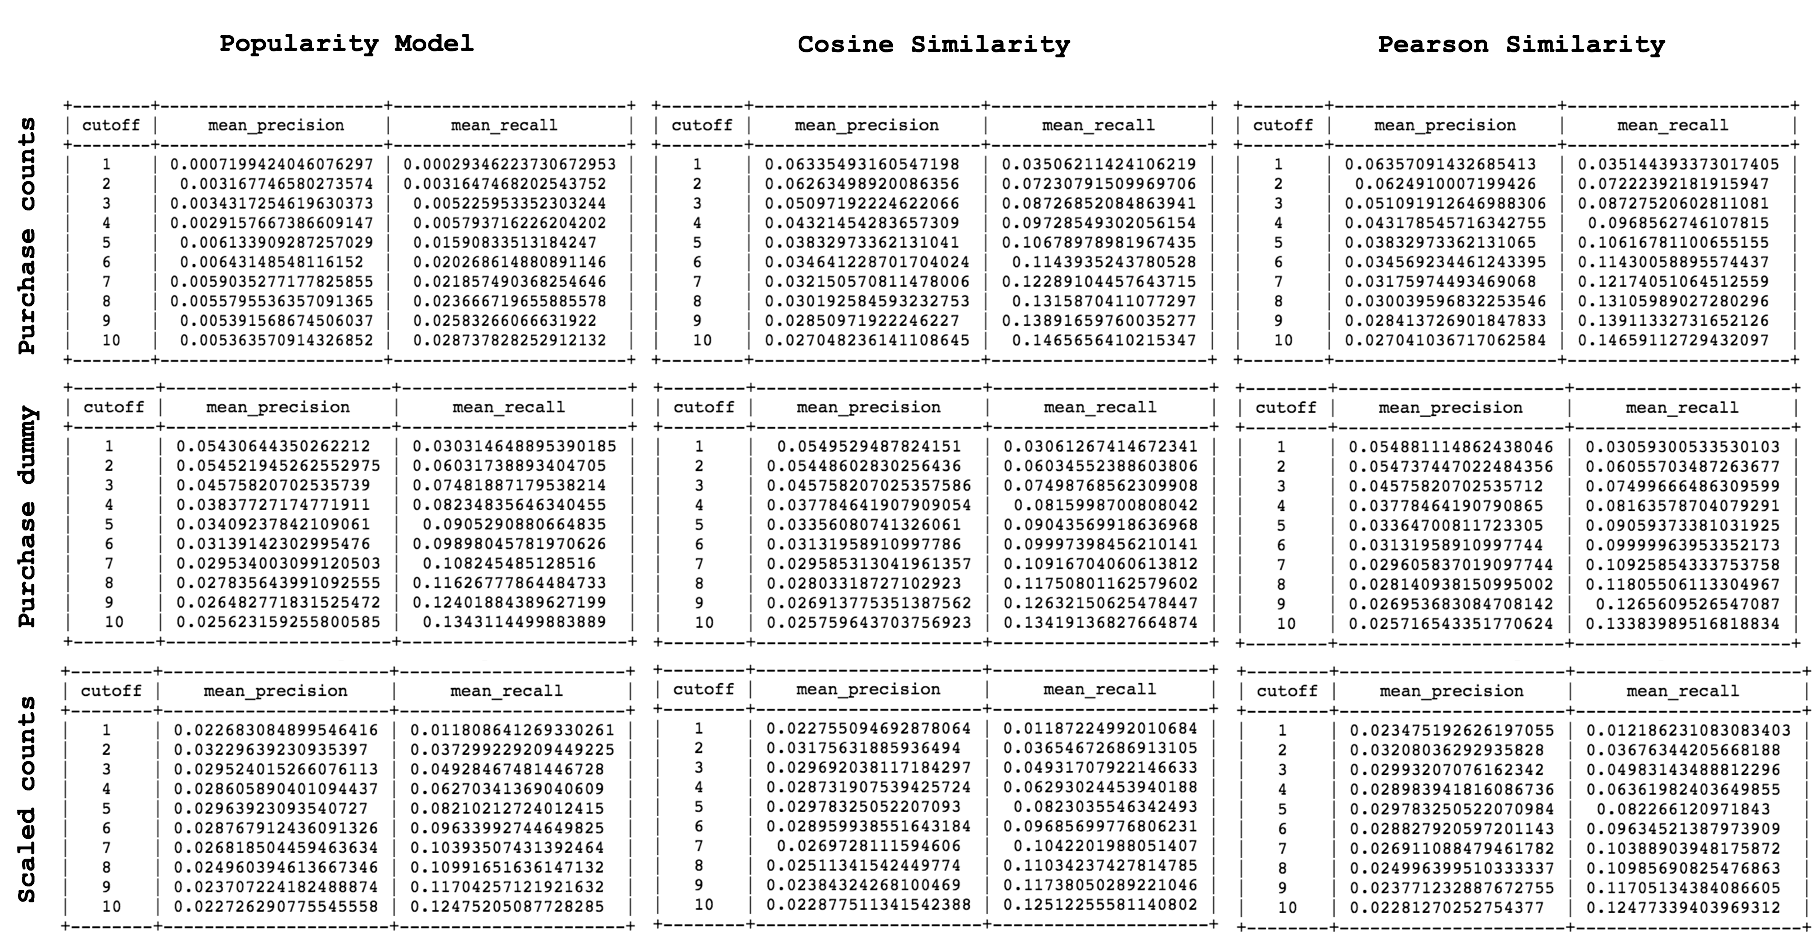

#### Notes

* Popularity v. Collaborative Filtering: We can see that the collaborative filtering algorithms work better than popularity model for purchase counts. Indeed, popularity model doesn’t give any personalizations as it only gives the same list of recommended items to every user.
* Precision and recall: Looking at the summary above, we see that the precision and recall for Purchase Counts > Purchase Dummy > Normalized Purchase Counts. However, because the recommendation scores for the normalized purchase data is zero and constant, we choose the dummy. In fact, the RMSE isn’t much different between models on the dummy and those on the normalized data.
* RMSE: Since RMSE is higher using pearson distance thancosine, we would choose model the smaller mean squared errors, which in this case would be cosine.
Therefore, we select the Cosine similarity on Purchase Dummy approach as our final model.

## Final Output
* In this step, we would like to manipulate format for recommendation output to one we can export to csv, and also a function that will return recommendation list given a customer ID.
* We need to first rerun the model using the whole dataset, as we came to a final model using train data and evaluated with test set.

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [139]:
users_to_recommend = list(customer_data[user_id])

final_model = tc.item_similarity_recommender.create(tc.SFrame(data_dummy), 
                                            user_id=user_id, 
                                            item_id=item_id, 
                                            target='purchase_dummy', 
                                            similarity_type='cosine')

recom = final_model.recommend(users=users_to_recommend, k=n_rec)
recom.print_rows(n_display)

Warning: Ignoring columns purchase_count;

To use these columns in scoring predictions, use a model that allows the use of additional features.

Preparing data set.

Data has 133585 observations with 24429 users and 300 items.

Data prepared in: 0.224542s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 1.468ms                        | 4          |

| 39.442ms                       | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 61.557ms                            | 0                | 0               |

| 154.45ms                            | 100              | 300             |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 0.18215s

recommendations finished on 1000/1000 queries. users per second: 37148.5

+------------+-----------+----------------------+------+
| customerId | productId |        score         | rank |
+------------+-----------+----------------------+------+
|    1553    |     35    | 0.10447167158126831  |  1   |
|    1553    |     1     | 0.10348175764083863  |  2   |
|    1553    |     2     |  0.0934672474861145  |  3   |
|    1553    |     5     | 0.07978436946868897  |  4   |
|    1553    |     17    | 0.06781145334243774  |  5   |
|    1553    |     33    |  0.0668614387512207  |  6   |
|    1553    |     61    | 0.06512556076049805  |  7   |
|    1553    |     15    | 0.06476415395736694  |  8   |
|    1553    |     21    |  0.063294517993927   |  9   |
|    1553    |     11    | 0.05467898845672607  |  10  |
|   20400    |     26    | 0.05812269449234009  |  1   |
|   20400    |     6     | 0.05361741781234741  |  2   |
|   20400    |    113    | 0.05312788486480713  |  3   |
|   20400    |     1     | 0.05210459232330322  |  4   |
|   20400    |     15    | 0.04

### CSV output file

In [140]:
df_rec = recom.to_dataframe()
print(df_rec.shape)
df_rec.head()

(10000, 4)


,customerId,productId,score,rank
0,1553,35,0.104472,1
1,1553,1,0.103482,2
2,1553,2,0.093467,3
3,1553,5,0.079784,4
4,1553,17,0.067811,5


In [166]:
df_rec['recommendedProducts'] = df_rec.groupby([user_id])[item_id]

ValueError: Length of values does not match length of index

In [162]:
df_rec['recommendedProducts'] = df_rec.groupby([user_id])[item_id].transform(lambda x: '|'.join(x.astype(str)))
df_output = df_rec[['customerId', 'recommendedProducts']]\
.drop_duplicates()\
.sort_values('customerId')\
.set_index('customerId')

#### Define a function to create a desired output

In [142]:
def create_output(model, users_to_recommend, n_rec, print_csv=True):
    recomendation = model.recommend(users=users_to_recommend, k=n_rec)
    df_rec = recomendation.to_dataframe()
    df_rec['recommendedProducts'] = df_rec.groupby([user_id])[item_id] \
        .transform(lambda x: '|'.join(x.astype(str)))
    df_output = df_rec[['customerId', 'recommendedProducts']].drop_duplicates() \
        .sort_values('customerId').set_index('customerId')
    if print_csv:
        df_output.to_csv(os.path.join(os.path.pardir,'data', 'processed','option1_recommendation.csv'))
        print("An output file can be found in 'data -> processed ' folder with name 'option1_recommendation.csv'")
    return df_output

In [151]:
df_output = create_output(cos, users_to_recommend, n_rec, print_csv=False)
print(df_output.shape)
df_output.head()

recommendations finished on 1000/1000 queries. users per second: 22288.1

(1000, 1)


,recommendedProducts
customerId,
4,2|1|15|14|5|268|77|64|36|272
11,2|0|5|44|13|38|15|146|51|134
12,82|2|20|118|44|1|8|94|134|79
16,2|82|1|5|47|8|106|36|14|15
21,38|2|1|131|8|48|45|82|79|63


###  Customer recommendation function

In [148]:
def customer_recomendation(customer_id):
    if customer_id not in df_output.index:
        print('Customer not found.')
        return customer_id
    return df_output.loc[customer_id]

In [152]:
customer_recomendation(4)

recommendedProducts    2|1|15|14|5|268|77|64|36|272
Name: 4, dtype: object

In [153]:
customer_recomendation(21)

recommendedProducts    38|2|1|131|8|48|45|82|79|63
Name: 21, dtype: object

## Summary
In this exercise, we were able to traverse a step-by-step process for making recommendations to customers. We used Collaborative Filtering approaches with `cosine` and `pearson` measure and compare the models with our baseline popularity model. We also prepared three sets of data that include regular buying count, buying dummy, as well as normalized purchase frequency as our target variable. Using RMSE, precision and recall, we evaluated our models and observed the impact of personalization. Finally, we selected the Cosine approach in dummy purchase data. 